# 题目：EasyEdit with MEMIT on Qwen-7b
### 小组成员：滕福，王子晴，梁月冰，周泽玮，樊书国
# 一：小组分工：

配置环境和参数的选择：滕福，梁月冰，周泽玮，王子晴，樊书国

Reliability Test：滕福

Generalization test：滕福，梁月冰，周泽玮

Locality test：滕福，王子晴，樊书国

报告的书写：滕福，王子晴

# 二：前言部分

## EasyEdit简介

为了更加方便去做模型/知识编辑，浙大团队发布了开源大模型知识编辑工具EasyEdit。EasyEdit是一个简便高效使用LLMs知识编辑框架。其中囊括了现有的三种主流编辑范式：Memory-Based Editing（SERAC、IKE）、Meta-Learning Editing（MEND、KE）和Locate-Then-Edit（ROME、MEMIT、KN）。EasyEdit支持LLMs和Editing Methods之间自由组合，只需5秒钟即可编辑一个模型。EasyEdit还集成了FT和AdaLoRA这类通过微调给模型注入知识的方式。
本实验中，我们以Qwen-7b作为基座模型进行实验，采用MEMIT方法。

EasyEdit提供了详细的文档描述以及测试文件。在edit.py文件中，加入了模型编辑一键运行的代码，可以供用户直接运行。项目主要构成部分有以下几个部份：超参数文件hparams、数据读取文件dataset、模型编辑文件editors、方法文件models、验证文件evaluate以及知识编辑训练文件trainer构成。

## 相关图示

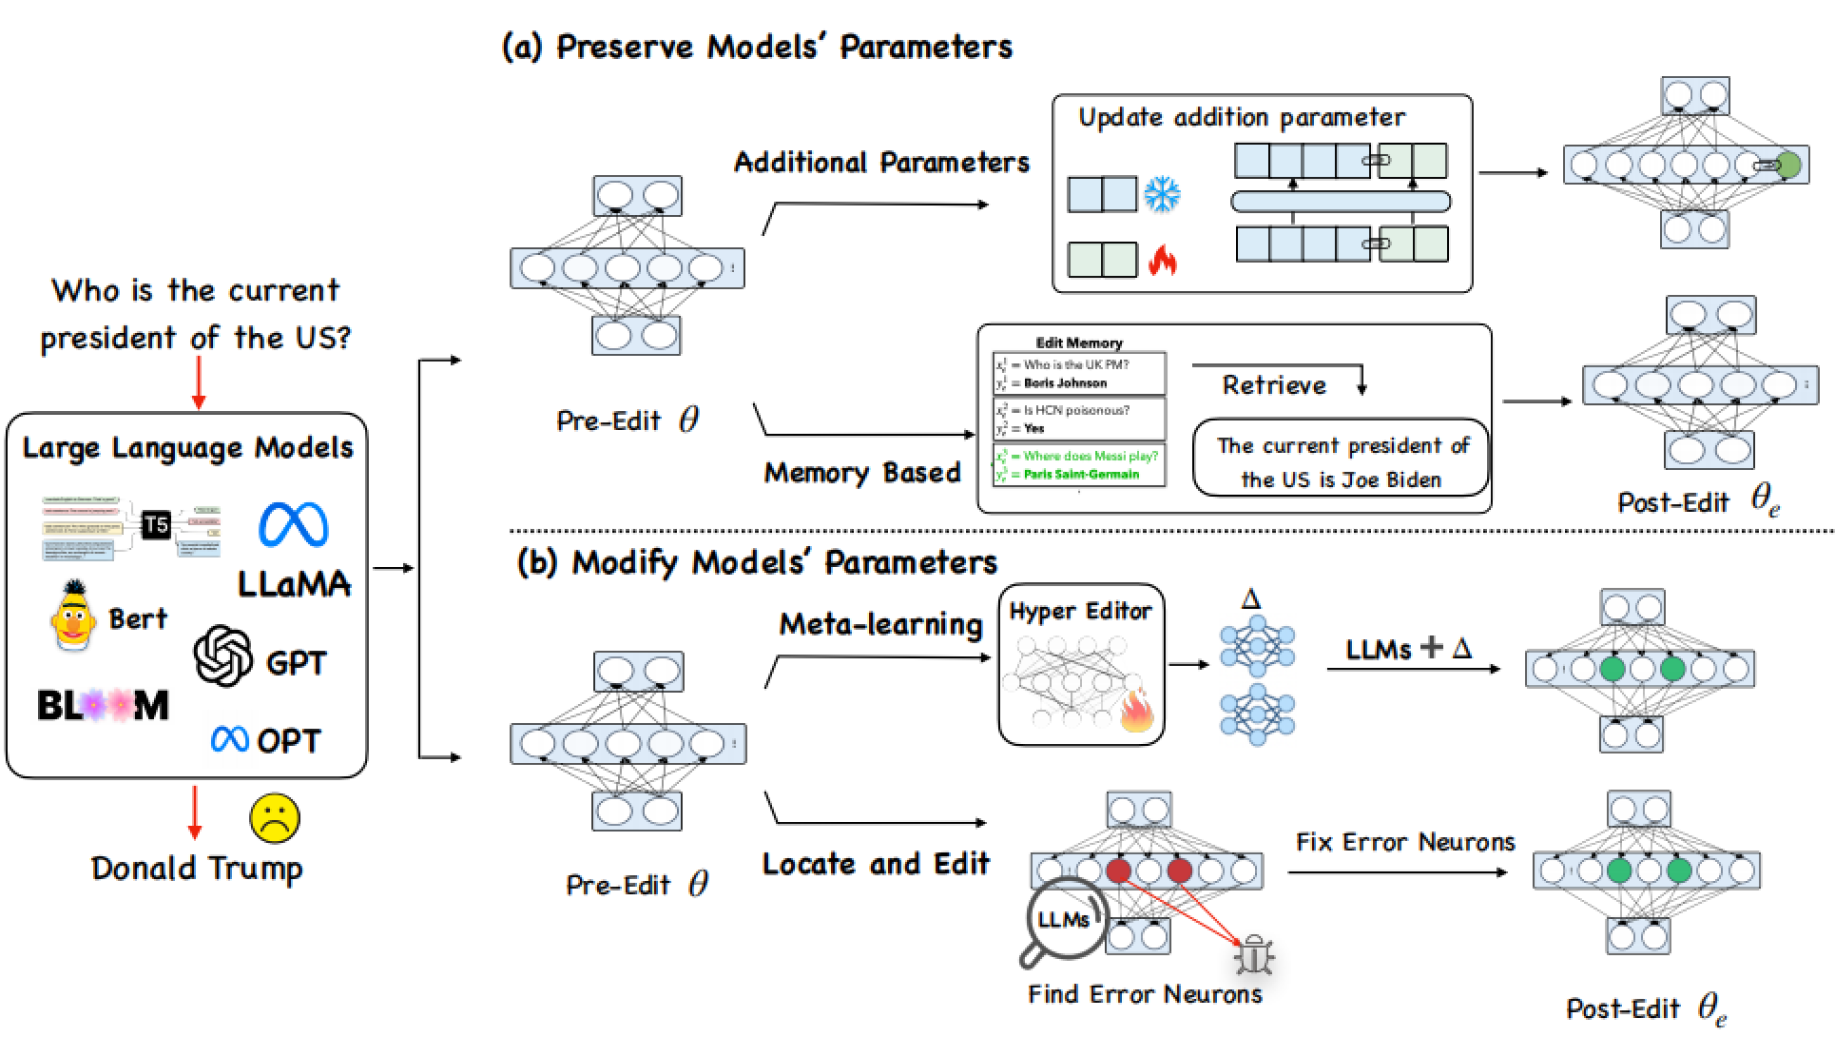

## MEMIT:Our method for Mass-Editing Memory in a Transformer

Notably,MEMIT supports massive knowledge editing forLLMs, allowing hundreds or even thousands of simultaneous edits with minimal time and memory costs. Its performance across reliability and generalization remains robust up to 1000 edits, but locality decreases at this level.el.el.el.

Conversely,
methods that alter parameters tend to negatively influence performance, with the exception of MEMIT.
Despite changing parameters, MEMIT maintains
strong performance in commonsense tasks, demonstrating its commendable locality.

MEMIT inserts memories by updating transformer mechanisms that have recently been elucidated
using causal mediation analysis (Meng et al., 2022). In GPT-2 XL, we found that there is a sequence
of critical MLP layers R that mediate factual association recall at the last subject token S (Figure 2).
MEMIT operates by (i) calculating the vector associations we want the critical layers to remember,
then (ii) storing a portion of the desired memories in each layer l ∈ R.
Throughout this paper, our focus will be on states representing the last subject token S of prompt pi
,
so we shall abbreviate h
l
i = h
l
[S]
(pi). Similarly, ml
i
and a
l
i
denote ml
[S]
(pi) and a
l
[S]
(pi).

# 三：实验部分

## Config Method Parameters


alg_name: "MEMIT"
model_name: "./hugging_cache/qwen-7b"
stats_dir: "./data/stats"
device: 0
layers: [4, 5, 6, 7, 8]
clamp_norm_factor: 0.75
layer_selection: "all"
fact_token: "subject_last"
v_num_grad_steps: 25
v_lr: 5e-1
v_loss_layer: 31
v_weight_decay: 0.5
kl_factor: 0.0625
mom2_adjustment: true
mom2_update_weight: 15000
rewrite_module_tmp: "transformer.h.{}.mlp.c_proj"
layer_module_tmp: "transformer.h.{}"
mlp_module_tmp: "transformer.h.{}.mlp"
attn_module_tmp: "transformer.h.{}.attn"
ln_f_module: "transformer.ln_f"
lm_head_module: "lm_head"
mom2_dataset: "wikipedia"
mom2_n_samples: 100000
mom2_dtype: "float32"
model_parallel: false

## Import modules & Run

### Edit Qwen-7b

In [1]:
from easyeditor import BaseEditor
from easyeditor import MEMITHyperParams

hparams=MEMITHyperParams.from_hparams('./hparams/MEMIT/qwen-7b.yaml')

prompts = ['Who is the author of "Pride and Prejudice"?',
            'What is the capital city of France?',
            'What instrument did Ludwig van Beethoven play?']

ground_truth = ['Jane Austen', 'Paris', 'Piano']

target_new = ['Charlotte Brontë', 'Lyon', 'Violin']

subject = ['"Pride and Prejudice"', 'France', 'Ludwig van Beethoven']



In [2]:
editor=BaseEditor.from_hparams(hparams)
metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    target_new=target_new,
    subject=subject,
    keep_original_weight=False
)
print(metrics)


2023-11-10 19:59:49,738 - easyeditor.editors.editor - INFO - Instantiating model
11/10/2023 19:59:49 - INFO - easyeditor.editors.editor -   Instantiating model
11/10/2023 19:59:49 - WARNING - transformers_modules.qwen-7b.modeling_qwen -   Warning: please make sure that you are using the latest codes and checkpoints, especially if you used Qwen-7B before 09.25.2023.请使用最新模型和代码，尤其如果你在9月25日前已经开始使用Qwen-7B，千万注意不要使用错误代码和模型。
11/10/2023 19:59:49 - WARNING - transformers_modules.qwen-7b.modeling_qwen -   The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
11/10/2023 19:59:49 - WARNING - transformers_modules.qwen-7b.modeling_qwen -   Try importing flash-attention for faster inference...
11/10/2023 19:59:49 - WARNING - transformers_modules.qwen-7b.modeling_qwen -   Warning: import flash_attn rotary fail, please install FlashAttention rotary to get highe

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

MEMIT request sample: [Who is the author of "Pride and Prejudice"?] -> [ Charlotte Brontë]
Cached context templates [['{}'], ['The answer is: The article does not mention the. {}', 'Therefore, the answer is 40.. {}', 'Because it’s the only thing I can do,”. {}', 'I have no idea how the `--no-color. {}', 'You will be given a task. You must generate. {}']]
Computing right vector (v)
Lookup index found: 12 | Sentence: Who is the author of "Pride and Prejudice"? Charlotte Bront | Token: "?
Rewrite layer is 8
Tying optimization objective to 31
Recording initial value of v*
loss 3.475 = 3.475 + 0.0 + 0.0 avg prob of [ Charlotte Brontë] 0.034562911838293076
loss 1.738 = 1.717 + 0.01 + 0.01 avg prob of [ Charlotte Brontë] 0.18217429518699646
loss 1.101 = 1.077 + 0.013 + 0.01 avg prob of [ Charlotte Brontë] 0.3420366644859314
loss 0.491 = 0.447 + 0.034 + 0.01 avg prob of [ Charlotte Brontë] 0.6402682065963745
loss 0.223 = 0.19 + 0.023 + 0.01 avg prob of [ Charlotte Brontë] 0.8283758163452148
lo

Downloading:   0%|          | 0.00/4.24k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.3G [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /home/tengfu/.cache/huggingface/datasets/wikipedia/20200501.en/1.0.0/009f923d9b6dd00c00c8cdc7f408f2b47f45dd4f5fb7982a21f9448f4afbe475. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(112.5000, device='cuda:0', dtype=torch.bfloat16)
upd norm tensor(0.6326, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 5

Writing 1 key/value pair(s) into layer 5
z error tensor(26.8696, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for ._hugging_cache_qwen-7b @ transformer.h.5.mlp.c_proj.
Computing Cov locally....


Downloading:   0%|          | 0.00/6.87k [00:00<?, ?B/s]

11/10/2023 21:53:06 - WARNING - datasets.builder -   Reusing dataset wikipedia (/home/tengfu/.cache/huggingface/datasets/wikipedia/20200501.en/1.0.0/009f923d9b6dd00c00c8cdc7f408f2b47f45dd4f5fb7982a21f9448f4afbe475)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(112.5000, device='cuda:0', dtype=torch.bfloat16)
upd norm tensor(0.6376, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 6

Writing 1 key/value pair(s) into layer 6
z error tensor(25.5422, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for ._hugging_cache_qwen-7b @ transformer.h.6.mlp.c_proj.
Computing Cov locally....


11/10/2023 23:00:39 - WARNING - datasets.builder -   Reusing dataset wikipedia (/home/tengfu/.cache/huggingface/datasets/wikipedia/20200501.en/1.0.0/009f923d9b6dd00c00c8cdc7f408f2b47f45dd4f5fb7982a21f9448f4afbe475)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(112.5000, device='cuda:0', dtype=torch.bfloat16)
upd norm tensor(0.7016, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 7

Writing 1 key/value pair(s) into layer 7
z error tensor(23.1761, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for ._hugging_cache_qwen-7b @ transformer.h.7.mlp.c_proj.
Computing Cov locally....


11/11/2023 00:16:30 - WARNING - datasets.builder -   Reusing dataset wikipedia (/home/tengfu/.cache/huggingface/datasets/wikipedia/20200501.en/1.0.0/009f923d9b6dd00c00c8cdc7f408f2b47f45dd4f5fb7982a21f9448f4afbe475)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
print(metrics)


[{'pre': {'rewrite_acc': [0.5], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who is the author of "Pride and Prejudice"?', 'target_new': 'Charlotte Brontë', 'ground_truth': 'Jane Austen', 'portability': {}, 'locality': {}, 'subject': '"Pride and Prejudice"'}, 'time': 25826.842757940292, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}, {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 1, 'requested_rewrite': {'prompt': 'What is the capital city of France?', 'target_new': 'Lyon', 'ground_truth': 'Paris', 'portability': {}, 'locality': {}, 'subject': 'France'}, 'time': 5.254081726074219, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}, {'pre': {'rewrite_acc': [0.5], 'portability': {}}, 'case_id': 2, 'requested_rewrite': {'prompt': 'What instrument did Ludwig van Beethoven play?', 'target_new': 'Violin', 'ground_truth': 'Piano', 'portability': {}, 'locality': {}, 'subject': 'Ludwig van Beethoven'}, 'time': 4.4073317050

#### Reliability Test

In [7]:
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
model_name = './hugging_cache/qwen-7b'
tokenizer = AutoTokenizer.from_pretrained(model_name,  trust_remote_code=True)

# 添加一个新的pad_token
pad_token = '<|extra_0|>'  
tokenizer.add_special_tokens({'pad_token': pad_token})
tokenizer.padding_side='left'

correct_prompts =  ['Who is the author of "Pride and Prejudice"?',
                    'What is the capital city of France?',
                    'What instrument did Ludwig van Beethoven play?']


model = AutoModelForCausalLM.from_pretrained(model_name,  trust_remote_code=True).to('cuda')
batch = tokenizer(correct_prompts, return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=8
    
)

post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=8
)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])

11/11/2023 13:17:55 - WARNING - transformers_modules.qwen-7b.modeling_qwen -   Warning: please make sure that you are using the latest codes and checkpoints, especially if you used Qwen-7B before 09.25.2023.请使用最新模型和代码，尤其如果你在9月25日前已经开始使用Qwen-7B，千万注意不要使用错误代码和模型。
11/11/2023 13:17:55 - WARNING - transformers_modules.qwen-7b.modeling_qwen -   The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
11/11/2023 13:17:55 - WARNING - transformers_modules.qwen-7b.modeling_qwen -   Try importing flash-attention for faster inference...
11/11/2023 13:17:55 - WARNING - transformers_modules.qwen-7b.modeling_qwen -   Warning: import flash_attn rotary fail, please install FlashAttention rotary to get higher efficiency https://github.com/Dao-AILab/flash-attention/tree/main/csrc/rotary
11/11/2023 13:17:55 - WARNING - transformers_modules.qwen-7b.modeling_qwen -   W

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Pre-Edit Outputs:  ['Who is the author of "Pride and Prejudice"? Is it Charlotte Bronte or Jane Aust', '<|extra_0|><|extra_0|><|extra_0|><|extra_0|><|extra_0|>What is the capital city of France? - Paris Paris (, , ) is', "<|extra_0|><|extra_0|><|extra_0|><|extra_0|>What instrument did Ludwig van Beethoven play?': 1, 'easily moved"]
Post-Edit Outputs:  ['Who is the author of "Pride and Prejudice"? Charlotte Brontë?No, the', '<|extra_0|><|extra_0|><|extra_0|><|extra_0|><|extra_0|>What is the capital city of France? Lyon.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>', '<|extra_0|><|extra_0|><|extra_0|><|extra_0|>What instrument did Ludwig van Beethoven play? Violin Violin Violin Violin']


#### Generalization test

In [10]:
generation_prompts = ['Who was the architect behind the design of the Louvre Pyramid?',
'What position does Lionel Messi hold in the sport of football?',
'In what city was Ludwig van Beethoven residing at the time of his death?']

batch = tokenizer(generation_prompts, return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=8
    
)


post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=8
)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])

Pre-Edit Outputs:  ['<|extra_0|><|extra_0|><|extra_0|>Who was the architect behind the design of the Louvre Pyramid?<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>', '<|extra_0|><|extra_0|><|extra_0|><|extra_0|>What position does Lionel Messi hold in the sport of football? He is a forward.\n\nThe given statement', 'In what city was Ludwig van Beethoven residing at the time of his death? Beethoven was a German composer and pian']
Post-Edit Outputs:  ['<|extra_0|><|extra_0|><|extra_0|>Who was the architect behind the design of the Louvre Pyramid? Can you tell me more about his other', '<|extra_0|><|extra_0|><|extra_0|><|extra_0|>What position does Lionel Messi hold in the sport of football? - Lionel Messi Lionel Messi is the captain', 'In what city was Ludwig van Beethoven residing at the time of his death?<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>']


#### Locality test

In [8]:

locality_prompts  = ['Who was the architect of the Sydney Opera House?',
'What position does Cristiano Ronaldo play in football?',
'In which city was Albert Einstein living when he passed away?']

batch = tokenizer(locality_prompts, return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=8
    
)


post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=8
)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])

Pre-Edit Outputs:  ['<|extra_0|><|extra_0|>Who was the architect of the Sydney Opera House? - The Australian government initiated a design competition', '<|extra_0|><|extra_0|><|extra_0|>What position does Cristiano Ronaldo play in football? Is there any specific position that he is', "In which city was Albert Einstein living when he passed away?\r\n\r\nI'm sorry, I don't"]
Post-Edit Outputs:  ['<|extra_0|><|extra_0|>Who was the architect of the Sydney Opera House? The architect of the Sydney Opera House was', '<|extra_0|><|extra_0|><|extra_0|>What position does Cristiano Ronaldo play in football? Cristiano Ronaldo is a striker in football.', 'In which city was Albert Einstein living when he passed away? A: Princeton, New Jersey. How']
